### Centro Universitário Senac  
**Professor:** Rafael Cóbe  
**Disciplina:** Introdução ao Aprendizado de Máquina  

### Exercício 3 - **Regressão Linear Multivariada**

**Renato Calabro (calabro@live.com)**
**Ágata Oliveira (agata.aso@hotmail.com)**
**Lucas Parisi (parisi.lucas@gmail.com)**
**Douglas Carvalho Rocha (douglas.particular@gmail.com)**
**Angel Guillermo Morales Romero (aguilhermemr@gmail.com)**

In [32]:
!../.venv/bin/python --version
%pip install -r ../requirements.txt
# %pip install numpy pandas matplotlib seaborn scikit-learn ipkernel
# %pip freeze > requirements.txt
%pip install gdown

Python 3.9.16
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
# !mkdir -p data/
# !gdown https://drive.google.com/uc?id=1zcsUU6neakc2_BnATvvsLekvMyz1cztM -O data/
# !gdown https://drive.google.com/uc?id=1zZdavmX2Zlhfe9up-25rXvE3v0HF9Ajd -O data/

# baixados manualmente para trabalhar fora do ambiente do Colab autenticado

In [34]:
import math

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [35]:
from pathlib import Path

base_path = Path("../datasets/regression_data")

In [36]:
advertising_file = base_path / "Advertising.csv"

if advertising_file.exists():
    df_advertising = pd.read_csv(
        advertising_file,
        sep=',',
    )
    df_advertising.rename(columns={df_advertising.columns[0]: 'id'}, inplace=True)
    display(df_advertising.head())
else:
    print(f"Arquivo não encontrado: {advertising_file.resolve()}")

,id,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [37]:
house_prices_file = base_path / "Portland_housePrices.csv"

if house_prices_file.exists():
    df_houses = pd.read_csv(
        house_prices_file,
        sep=',',
    )
    display(df_houses.head())
else:
    print(f"Arquivo não encontrado: {house_prices_file.resolve()}")

,tamanho,quartos,preco
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


#### Para cada um dos conjuntos de treinamento, utilize a função <i>fit</i> múltiplas vezes considerando apenas <i>um</i> atributo preditor.

##### O modelo aprendido muda a cada vez que a função <i>fit</i> é utilizada?

In [38]:
# Housing dataset
X = df_houses[['tamanho']]
y = df_houses[['preco']].values.ravel()

for i in range(3):
    lr_model = SGDRegressor()
    lr_model.fit(X, y)
    y_pred = lr_model.predict(X)

    print(f"SGDRegressor - Iteration {i+1}")
    print("Coefficients:", lr_model.coef_)
    print("MSE:", mean_squared_error(y, y_pred))
    print("R2:", r2_score(y, y_pred))

SGDRegressor - Iteration 1
Coefficients: [1.36489207e+12]
MSE: 8.608318687398644e+30
R2: -5.625500016961364e+20
SGDRegressor - Iteration 2
Coefficients: [-1.18791705e+12]
MSE: 6.520871156535583e+30
R2: -4.2613618447226785e+20
SGDRegressor - Iteration 3
Coefficients: [-8.23357606e+11]
MSE: 3.132748080858725e+30
R2: -2.0472376804316512e+20


In [39]:
# Advertising dataset
df_advertising_train = df_advertising.drop(columns=['id'], inplace=False)
X = df_advertising_train[['TV']]
y = df_advertising_train[['sales']].values.ravel()

for i in range(3):
    lr_model = SGDRegressor()
    lr_model.fit(X, y)
    y_pred = lr_model.predict(X)

    print(f"SGDRegressor - Iteration {i+1}")
    print("Coefficients:", lr_model.coef_)
    print("MSE:", mean_squared_error(y, y_pred))
    print("R2:", r2_score(y, y_pred))

SGDRegressor - Iteration 1
Coefficients: [2.93612619e+10]
MSE: 2.493604129385486e+25
R2: -9.206334344743573e+23
SGDRegressor - Iteration 2
Coefficients: [2.98938553e+11]
MSE: 2.5913409389794476e+27
R2: -9.567176603667926e+25
SGDRegressor - Iteration 3
Coefficients: [-7.28035417e+10]
MSE: 1.5335914832640622e+26
R2: -5.66198771360695e+24


Sim, o modelo muda a cada execução do `fit`, mesmo com os mesmos dados, porque o `SGDRegressor` **não é determinístico por padrão**. 

Isso ocorre porque ele utiliza **descida do gradiente estocástica**, que envolve:

- Inicialização aleatória dos coeficientes
- Embaralhamento dos dados em cada passada

Diferente da regressão linear clássica (analítica), que sempre gera os mesmos coeficientes para os mesmos dados, o `SGDRegressor` pode gerar resultados diferentes a cada treino. Para tornar o comportamento reprodutível, defina o parâmetro `random_state`.


##### Os modelos finais aprendidos são os mesmos da outra implementação de regressão linear?

Não necessariamente. `LinearRegression` resolve a equação analítica de mínimos quadrados, obtendo os coeficientes exatos. Já o `SGDRegressor` é um método iterativo e pode convergir para soluções **aproximadas** e **variáveis**, dependendo da taxa de aprendizado, número de épocas e aleatoriedade.

#### Aprenda modelos utilizando todos os atributos de entrada.

##### Baseado no RSS e no R^2, é possível obter um modelo melhor utilizando todos os dados?

Sim. Em geral, utilizar mais atributos informativos tende a **reduzir o RSS** (Residual Sum of Squares) e **aumentar o R²**, indicando melhor ajuste. No entanto, isso depende da **relevância dos atributos** e da presença de multicolinearidade.

##### Existem atributos que poderiam ser desconsiderados sem que fosse afetada a precisão?

Sim. Se um atributo apresenta **baixa correlação com a variável-alvo** ou é **redundante** (altamente correlacionado com outro atributo), ele pode ser removido sem perda significativa de desempenho. Técnicas como análise de correlação ou regularização (`Lasso`) ajudam a identificar esses casos.

Por exemplo:
- `newspaper`: correlação com `sales` é baixa (**0.23**), podendo ser removido sem grande perda de desempenho.
- `id`: é apenas um identificador, com correlação praticamente nula (**-0.05**) e **deve ser descartado**.

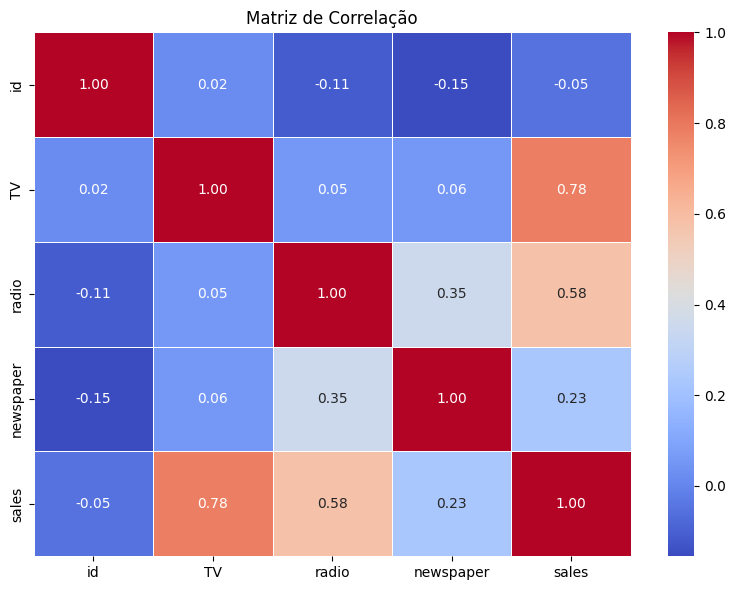

In [40]:
correlation_matrix = df_advertising.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()

##### Qual implementação treina mais rápido? A com método dos mínimos quadrados ou a com descida de gradiente?

- Em datasets pequenos como este, **`LinearRegression`** (mínimos quadrados) é **mais rápida e precisa**, pois resolve a equação diretamente.
- O `SGDRegressor` é vantajoso **apenas em grandes volumes de dados**, onde métodos exatos tornam-se computacionalmente caros.

#### Realizar a análise da qualidade dos preditores utilizados no modelo construído.

##### Construir o plot de resíduos. Será que os resíduos estão aleatoriamente distribuídos ao redor de 0?

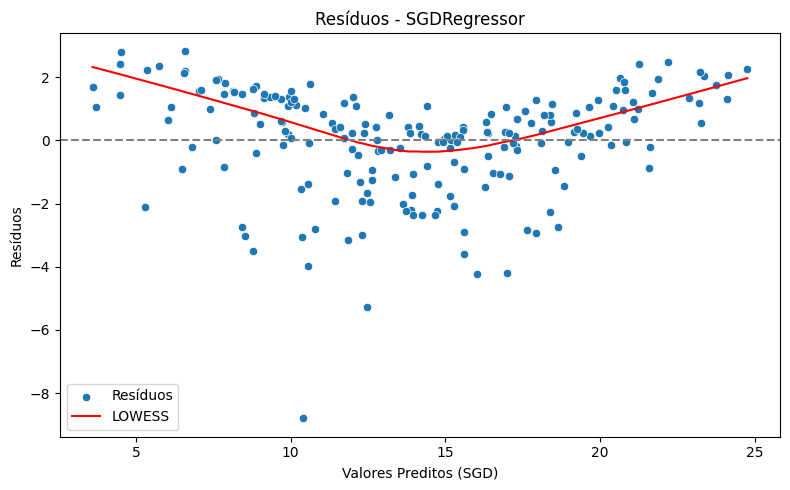

In [41]:
X = df_advertising[['TV', 'radio', 'newspaper']]
y = df_advertising['sales']

model = make_pipeline(StandardScaler(), SGDRegressor(random_state=42, max_iter=1000, tol=1e-3))
model.fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

# Plot de resíduos com LOWESS manual
from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(residuals, y_pred)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, label="Resíduos")
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='LOWESS')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Valores Preditos (SGD)")
plt.ylabel("Resíduos")
plt.title("Resíduos - SGDRegressor")
plt.legend()
plt.tight_layout()
plt.show()

Os resíduos **não estão aleatoriamente distribuídos ao redor de 0**, como evidenciado pelo padrão em forma de "U" no gráfico.

Isso indica que o modelo linear com `SGDRegressor` **não está capturando adequadamente a relação entre os preditores e a variável resposta** (`sales`). Há sinais claros de **comportamento não linear**, o que viola uma das principais suposições da regressão linear.

> **Conclusão:** o modelo apresenta indícios de subajuste (underfitting) e poderia ser melhorado com transformações polinomiais ou uso de modelos não lineares.


##### Calcular os valores p para os preditores utilizados no modelo de regressão. Utilize [esse link](https://stackoverflow.com/a/42677750) como referência. Utilizar essa técnica para selecionar variáveis preditivas. Comparar o desempenho do modelo construído a partir de variáveis preditivas com melhores valores p com um modelo que contêm todas as variáveis.

In [42]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = df_advertising[['TV', 'radio', 'newspaper']]
y = df_advertising['sales']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           1.58e-96
Time:                        15:52:28   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

In [43]:
X_full = df_advertising[['TV', 'radio', 'newspaper']]
model_full = LinearRegression().fit(X_full, y)
y_pred_full = model_full.predict(X_full)

X_sig = df_advertising[['TV', 'radio']]
model_sig = LinearRegression().fit(X_sig, y)
y_pred_sig = model_sig.predict(X_sig)

print("Modelo Completo:")
print("R²:", r2_score(y, y_pred_full))
print("MSE:", mean_squared_error(y, y_pred_full))

print("\nModelo Reduzido (TV + radio):")
print("R²:", r2_score(y, y_pred_sig))
print("MSE:", mean_squared_error(y, y_pred_sig))

Modelo Completo:
R²: 0.8972106381789522
MSE: 2.784126314510936

Modelo Reduzido (TV + radio):
R²: 0.8971942610828957
MSE: 2.784569900338091


O valor-p (`P>|t|`) indica se o coeficiente de uma variável é estatisticamente diferente de zero. Quanto menor o valor-p (idealmente **< 0.05**), maior a evidência de que o preditor tem influência significativa na variável resposta.

Na regressão com `statsmodels`, obtivemos:

- `TV` (p ≈ 0.000): **significativo**
- `radio` (p ≈ 0.000): **significativo**
- `newspaper` (p = 0.860): **não significativo**

Com base nisso, construímos dois modelos:

**Modelo Completo** (`TV`, `radio`, `newspaper`)
- **R²:** 0.897
- **MSE:** 2.784


**Modelo Reduzido** (`TV`, `radio`)
- **R²:** 0.897
- **MSE:** 2.785

**Conclusão**

Remover o preditor `newspaper` (que tem valor-p alto) **não afetou o desempenho do modelo**, que manteve o mesmo poder explicativo. Portanto, `TV` e `radio` são suficientes para explicar `sales`, resultando em um modelo mais enxuto e eficaz.



#### Realizar o teste para descobrir multicolinearidade entre variáveis preditivas;

Utilizando [esse link](https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/) fazer o cáclulo do fator de inflação da variância (*Variance Inflation Factor - VIF*). Existe alguma evidência de multicolinearidade entre as variáveis preditivas?

In [44]:


X_vif = add_constant(df_advertising[['TV', 'radio', 'newspaper']])

# Cálculo dos VIFs
vif_data = pd.DataFrame()
vif_data['Variável'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


    Variável       VIF
0      const  6.848900
1         TV  1.004611
2      radio  1.144952
3  newspaper  1.145187


> Todos os valores de VIF estão **bem abaixo de 5**, indicando **ausência de multicolinearidade significativa** entre os preditores.
Não há evidências de que os preditores estejam linearmente correlacionados entre si de forma preocupante. O modelo é estável com relação à multicolinearidade.
